[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239412-lesson-5-router)

# Router

## Review

We built a graph that uses `messages` as state and a chat model with bound tools.

We saw that the graph can:

* Return a tool call
* Return a natural language response

## Goals

We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

This is a simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly. 

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

Let's extend our graph to work with either output! 

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model output, and route to our tool calling node or simply end if no tool call is performed. 



In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
#import os, getpass

#def _set_env(var: str):
    #if not os.environ.get(var):
        #os.environ[var] = getpass.getpass(f"{var}: ")

#_set_env("OPENAI_API_KEY")

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_openai import ChatOpenAI

def subtract(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a - b

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([subtract])

C:\Users\Aniket\Documents\Clg\LLM - part 2\myllm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 We use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it. 
 
 We use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge.

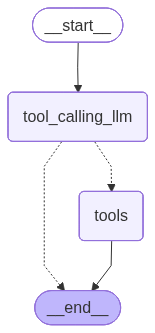

In [6]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([subtract]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, what is 2 subtracted by 2?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what is 2 subtracted by 2?
================================== Ai Message ==================================
Tool Calls:
  subtract (call_da3j8srTjV6QkxOoXkNVp96B)
 Call ID: call_da3j8srTjV6QkxOoXkNVp96B
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: subtract

0


In [8]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello , who is the best cricketer")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello , who is the best cricketer
================================== Ai Message ==================================

Determining the "best" cricketer is subjective and depends on various criteria such as format (Test, ODI, T20), statistical achievements, personal preferences, and impact on the game. Historically, players like Sir Donald Bradman, Sachin Tendulkar, Viv Richards, and Garfield Sobers are often mentioned as some of the greatest. In the modern era, players like Virat Kohli, Steve Smith, and Kane Williamson are highly regarded. Each has their own strengths and records that contribute to their standing in cricket history.


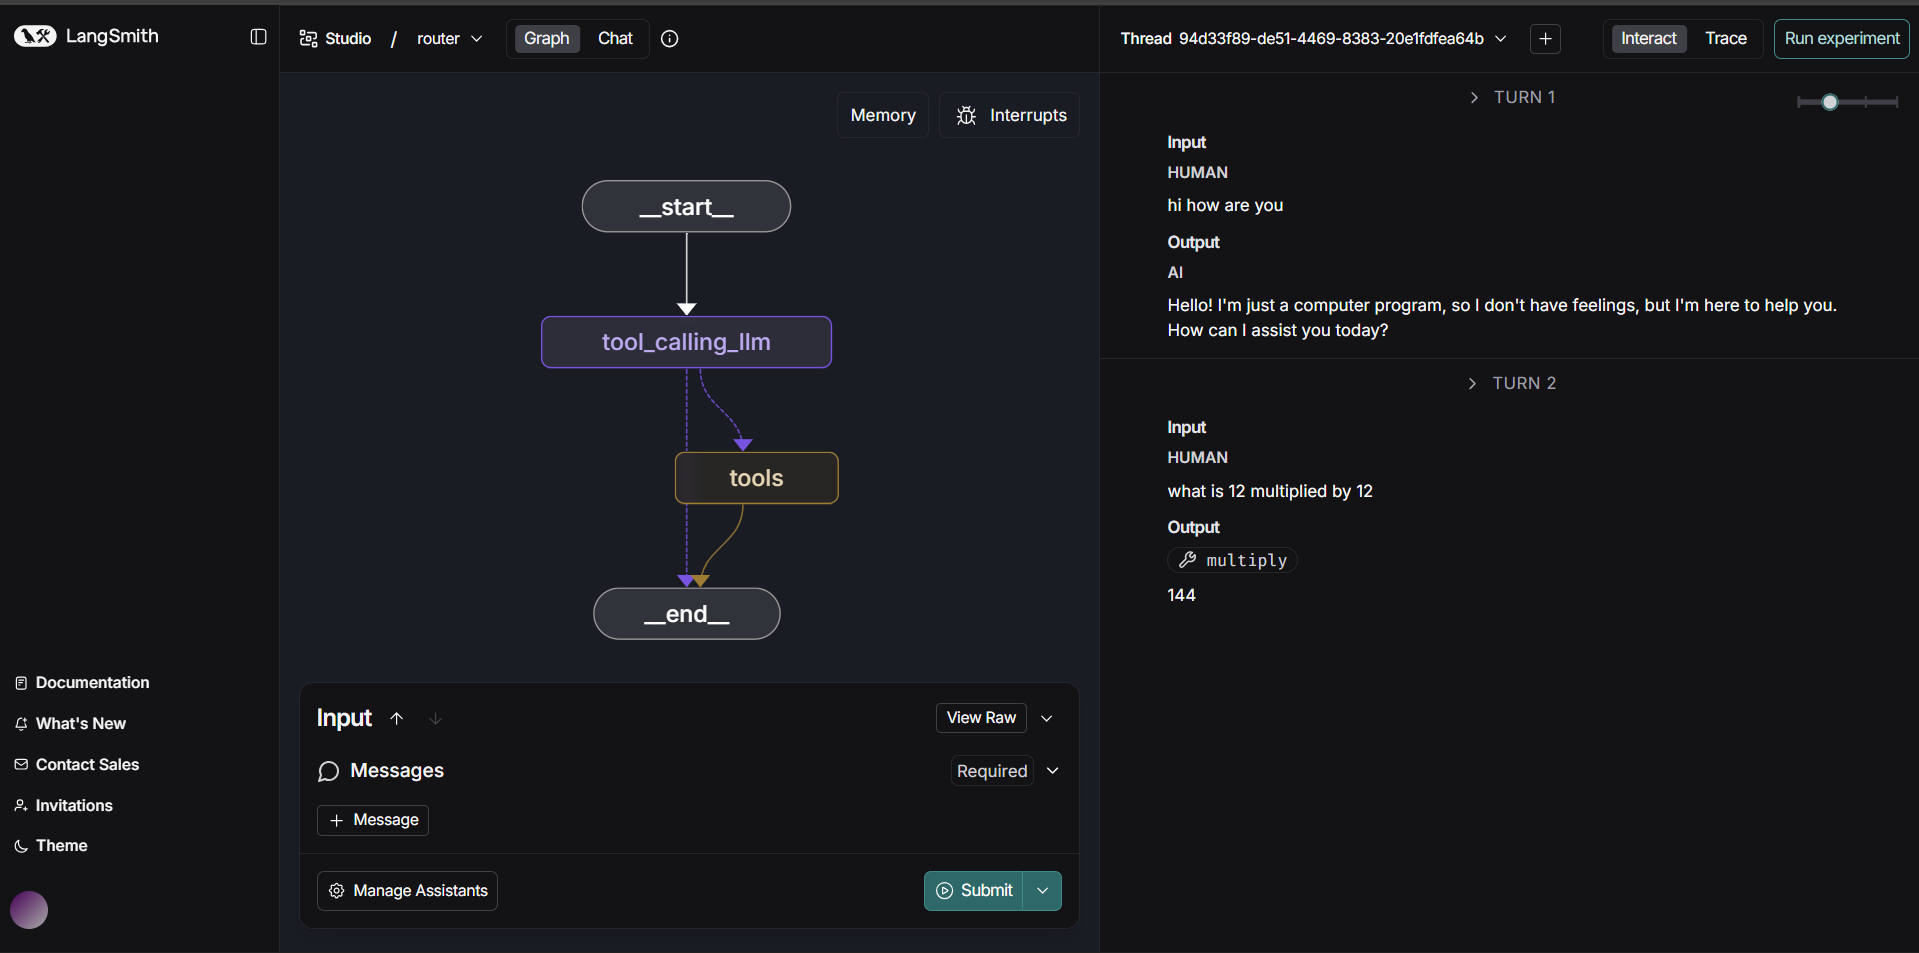

Now, we can see that the graph runs the tool!

It responds with a `ToolMessage`. 

## LangGraph Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.
Load the `router` in Studio, which uses `module-1/studio/router.py` set in `module-1/studio/langgraph.json`.

In [7]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")